In [1]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

rootFolder = os.getcwd()
os.chdir(rootFolder)
print(rootFolder)
folder = os.listdir('WeiseEtAl2023/cells/')
folder = sorted(folder)

savedata = 1 # Save Netpyne and BBP soma_voltage

/home/fernando/Dropbox/Extracellular_stimulation_NetPyNE/test


In [2]:
folder[15:20]

['L5_TTPC2_cADpyr232_1',
 'L5_TTPC2_cADpyr232_2',
 'L5_TTPC2_cADpyr232_3',
 'L5_TTPC2_cADpyr232_4',
 'L5_TTPC2_cADpyr232_5']

In [3]:
def loadTemplateName(cellnumber):     
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[14:-1]    
    return templatename

In [4]:
cellnumber = 15 
cellName = folder[cellnumber]
outFolder = rootFolder+'/WeiseEtAl2023/cells/'+folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
print ("CellNumber = %d" % cellnumber)
print ("CellName = %s" % cellName)
print ("TemplateName = %s" % cellTemplateName)

with open(outFolder + '/current_amps.dat') as current_file:
    current_content = current_file.read()

holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]
# step1_current = step2_current
print ('load step1_current from current_amps.dat = %s' % step1_current)

CellNumber = 15
CellName = L5_TTPC2_cADpyr232_1
TemplateName = cADpyr232_L5_TTPC2_8052133265
load step1_current from current_amps.dat = 0.5930628


In [5]:
holding_current, step1_current/1.5, step2_current/2., step3_current/2.5

(-0.286011, 0.3953752, 0.32124235, 0.27676264)

In [6]:
step1_current = holding_current + step1_current/1.25
step1_current

0.18843924

In [7]:
os.chdir(rootFolder)
# !nrnivmodl WeiseEtAl2023/mechanisms/

In [8]:
from netpyne import sim, specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = 1000 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -70}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['L5_TTPC']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'},
                    'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},
                    'V_axon_1': {'sec':'axon_1', 'loc':0.5, 'var':'v'},
                    'V_apic_0': {'sec':'apic_0', 'loc':0.5, 'var':'v'},
                    'V_apic_5': {'sec':'apic_5', 'loc':0.5, 'var':'v'},
                    'V_apic_95': {'sec':'apic_95', 'loc':0.5, 'var':'v'},
                    'V_apic_100': {'sec':'apic_100', 'loc':0.5, 'var':'v'},
                    'V_dend_0': {'sec':'dend_0', 'loc':0.5, 'var':'v'},
                    'V_dend_5': {'sec':'dend_5', 'loc':0.5, 'var':'v'},
                    'V_dend_65': {'sec':'dend_65', 'loc':0.5, 'var':'v'},
                    'V_dend_70': {'sec':'dend_70', 'loc':0.5, 'var':'v'}}


## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.025         


cfg.recordLFP = [[0, y, 0] for y in [-400]] # 1 elec on skull


cfg.simLabel = 'S1_L5_TTPC'
cfg.saveFolder = '.'
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			##  
cfg.saveCellConns = False		##  

cfg.analysis['plotTraces'] = {'include': ['L5_TTPC'], 'figSize': (12, 4), 'saveFig': False, 'overlay': True, 'oneFigPer': 'cell'}  # Plot recorded traces for this list of cells


#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

cfg.IClamp1 = {'pop': 'L5_TTPC', 'sec': 'soma_0', 'loc': 0.5, 'start': 1000, 'dur': 1000, 'amp': step1_current}
# cfg.IClamp2 = {'pop': 'L5_TTPC', 'sec': 'apic_98', 'loc': 0.5, 'start': 700, 'dur': 25, 'amp': step1_current}
# cfg.IClamp3 = {'pop': 'L5_TTPC', 'sec': 'apic_99', 'loc': 0.5, 'start': 900, 'dur': 25, 'amp': step1_current}
# cfg.IClamp4 = {'pop': 'L5_TTPC', 'sec': 'apic_100', 'loc': 0.5, 'start': 1100, 'dur': 25, 'amp': step1_current}


netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
#StochKv_deterministic.mod
cellName = folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
    conds={'cellType': cellName, 'cellModel': 'HH_full'},
    fileName='cellwrapper3.py',
    cellName='loadCell',
    cellInstance = True,
    cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------

## Population parameters
# pyr_positions = [[x , y , 0] for x in range(100,1100,300) for y in range(100,1100,300)]
pyr_positions = [[x-857 , x , 0] for x in range(857,1382,250)]
cellsList = [{'x': x, 'y': y, 'z': z} for x,y,z in pyr_positions]
netParams.popParams['L5_TTPC'] = {'cellType': cellName, 'cellModel': 'HH_full', 'cellsList': cellsList} 


# #------------------------------------------------------------------------------
# #  extracellular mechs
# #------------------------------------------------------------------------------
for celltyp in netParams.cellParams.keys():
    label = []
    for secname in netParams.cellParams[celltyp]['secs'].keys():
        netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular'] = {}

#-----------------------------------------------------------------------------------#
for cellMe in netParams.cellParams.keys():
    axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['soma_0']['geom']['pt3d'][-1]
    axon_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['diam']
    axon_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['L']

    netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'] = [(axon_pt3d_x, axon_pt3d_y, axon_pt3d_z, axon_pt3d_diam),
                                                                      (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L/2.0, axon_pt3d_z, axon_pt3d_diam),
                                                                      (axon_pt3d_x, axon_pt3d_y+axon_pt3d_L, axon_pt3d_z, axon_pt3d_diam)]

    axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, soma_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_0']['geom']['pt3d'][-1]
    axon1_pt3d_diam =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['diam']
    axon1_pt3d_L =  netParams.cellParams[cellMe]['secs']['axon_1']['geom']['L']

    netParams.cellParams[cellMe]['secs']['axon_1']['geom']['pt3d'] = [(axon1_pt3d_x, axon1_pt3d_y, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L/2.0, axon1_pt3d_z, axon1_pt3d_diam),
                                                                          (axon1_pt3d_x, axon1_pt3d_y+axon1_pt3d_L, axon1_pt3d_z, axon1_pt3d_diam)] 
        

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

        
netParams.rotateCellsRandomly = [0, 6.2832]
# sim.createSimulateAnalyze(netParams, cfg)     

	1 
	1 
	1 


In [9]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)


Start time:  2024-04-15 16:38:54.891274

Creating network of 1 cell populations on 1 hosts...
  Number of cells on node 0: 3 
  Done; cell creation time = 0.20 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 3 
  Done; cell stims creation time = 0.00 s.
Recording 36 traces of 12 types on node 0


{spkt: Vector[33038], spkid: Vector[33039], stims: {cell_0: {}, cell_1: {}, cell_2: {}}, V_soma: {cell_0: Vector[33073], cell_1: Vector[33084], cell_2: Vector[33095]}, V_axon_0: {cell_0: Vector[33074], cell_1: Vector[33085], cell_2: Vector[33096]}, V_axon_1: {cell_0: Vector[33075], cell_1: Vector[33086], cell_2: Vector[33097]}, V_apic_0: {cell_0: Vector[33076], cell_1: Vector[33087], cell_2: Vector[33098]}, V_apic_5: {cell_0: Vector[33077], cell_1: Vector[33088], cell_2: Vector[33099]}, V_apic_95: {cell_0: Vector[33078], cell_1: Vector[33089], cell_2: Vector[33100]}, V_apic_100: {cell_0: Vector[33079], cell_1: Vector[33090], cell_2: Vector[33101]}, V_dend_0: {cell_0: Vector[33080], cell_1: Vector[33091], cell_2: Vector[33102]}, V_dend_5: {cell_0: Vector[33081], cell_1: Vector[33092], cell_2: Vector[33103]}, V_dend_65: {cell_0: Vector[33082], cell_1: Vector[33093], cell_2: Vector[33104]}, V_dend_70: {cell_0: Vector[33083], cell_1: Vector[33094], cell_2: Vector[33105]}, t: Vector[33106],


 {'cellType': 'L5_TTPC2_cADpyr232_1', 'cellModel': 'HH_full', 'pop': 'L5_TTPC', 'x': 0, 'y': 857, 'z': 0, 'xnorm': 0.0, 'ynorm': 8.57, 'znorm': 0.0}

 {'cellType': 'L5_TTPC2_cADpyr232_1', 'cellModel': 'HH_full', 'pop': 'L5_TTPC', 'x': 250, 'y': 1107, 'z': 0, 'xnorm': 2.5, 'ynorm': 11.07, 'znorm': 0.0}

 {'cellType': 'L5_TTPC2_cADpyr232_1', 'cellModel': 'HH_full', 'pop': 'L5_TTPC', 'x': 500, 'y': 1357, 'z': 0, 'xnorm': 5.0, 'ynorm': 13.57, 'znorm': 0.0}
0.0s

Running simulation using NEURON for 1000.0 ms...
0.5s
1.0s
  Done; run time = 384.38 s; real-time ratio: 0.00.

Gathering data...
  Done; gather time = 0.12 s.

Analyzing...
  Cells: 3
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 384.38 s
   L5_TTPC : 0.000 Hz
Plotting recorded cell traces ... cell


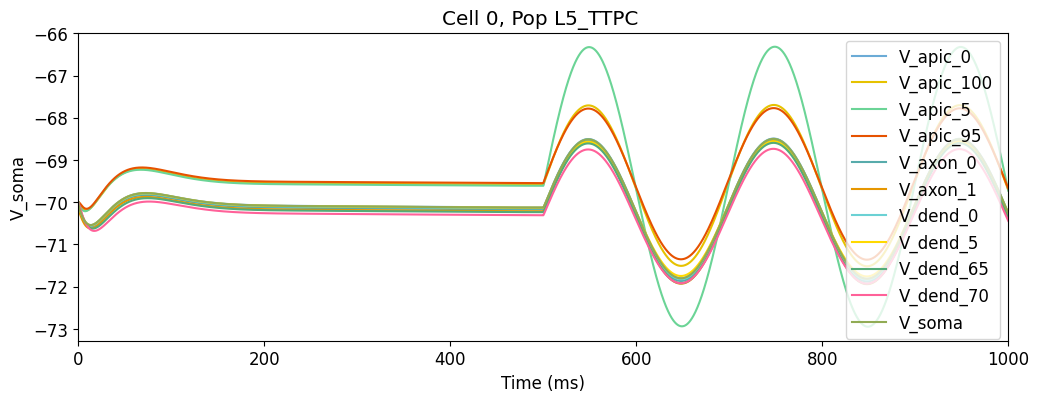

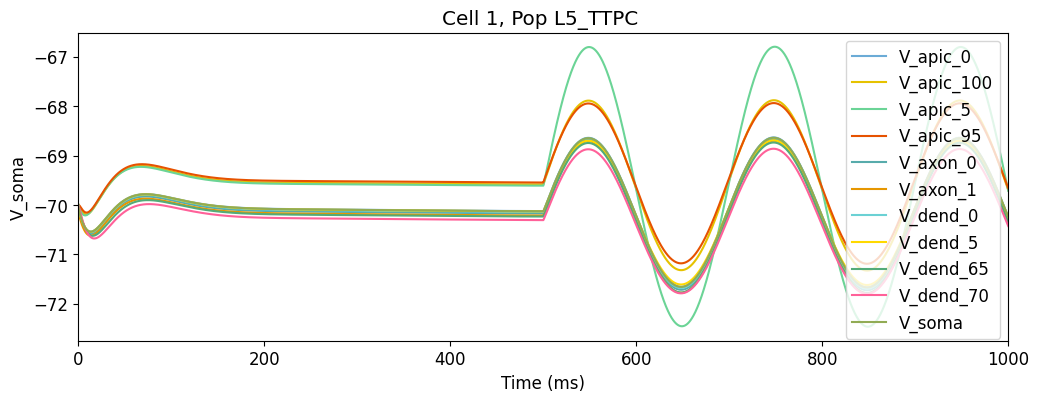

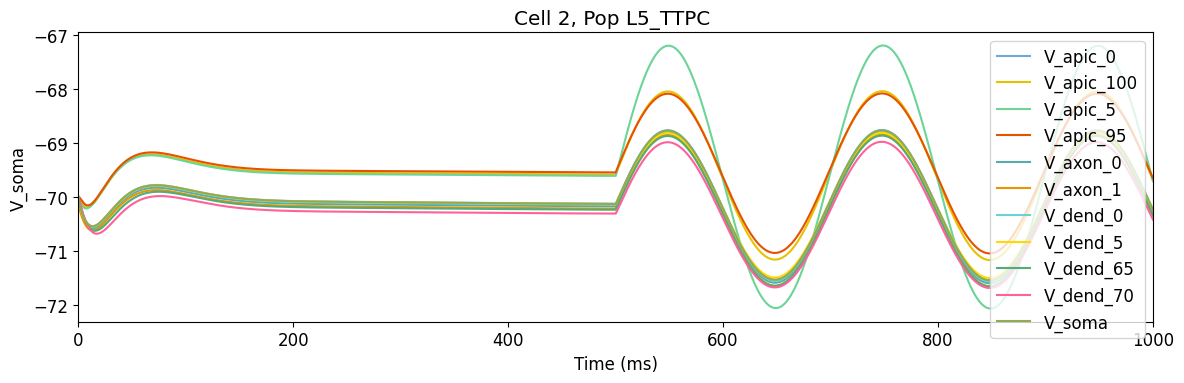

  Done; plotting time = 3.72 s

Total time = 390.25 s
Plotting 3D cell shape ...


(<Figure size 640x480 with 1 Axes>, {})

In [10]:
def collect_pt3d(self, section):
        """        collect the pt3d info, for each section
        """
        n3dsec = 0
        r3dsec = np.zeros(3)
        for sec in [sec for secName, sec in self.secs.items() if section in secName]:
            sec['hObj'].push()
            n3d = int(neuron.h.n3d())  # get number of n3d points in each section
            # print("get number of n3d points in each section",n3d)
            r3d = np.zeros((3, n3d))  # to hold locations of 3D morphology for the current section
            n3dsec += n3d

            for i in range(n3d):
                r3dsec[0] += neuron.h.x3d(i)
                r3dsec[1] += neuron.h.y3d(i)
                r3dsec[2] += neuron.h.z3d(i)
            
            neuron.h.pop_section()

        r3dsec /= n3dsec
        
        return r3dsec
    
def getSecsPos(self, secList):
        """        Get Secs position
        """
        x3d, y3d, z3d = [], [], []
        
        for secName in secList:
            # print(secName)
            r3dsec = collect_pt3d(self, secName)
            # print(secName, r3dsec)
            
            x3d.append(r3dsec[0])
            y3d.append(r3dsec[1])
            z3d.append(r3dsec[2])
            
        return x3d, y3d, z3d
    
def insert_v_ext(self, v_ext, t_ext):

    self.t_ext = neuron.h.Vector(t_ext)
    self.v_ext = []
    for v in v_ext:
        self.v_ext.append(neuron.h.Vector(v))
    
    # play v_ext into e_extracellular reference
    i = 0
    for secName, sec in self.secs.items(): 
        # print(secName,i)
        self.v_ext[i].play(sec['hObj'](0.5)._ref_e_extracellular, self.t_ext)
        i += 1
  
def make_extracellular_stimuli(acs_params, self, secList):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = acs_params['position']
    ext_field = np.vectorize(lambda x, y, z: 1 / (4 * np.pi *
                                                  (acs_params['sigma'] * 
                                                   np.sqrt((x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2) + skull_attenuation)))

    stimstart = acs_params['stimstart']
    stimend = acs_params['stimend']
    stimdif = stimend-stimstart

    # MAKING THE EXTERNAL FIELD
    n_tsteps = int(stimdif / cfg.dt + 1)
    n_start = int(stimstart/cfg.dt)
    n_end = int(stimend/cfg.dt + 1)
    t = np.arange(start=n_start, stop=n_end) * cfg.dt
    pulse = acs_params['amp'] * 1000. * \
        np.sin(2 * np.pi * acs_params['frequency'] * t / 1000)

    totnsegs = len(secList)    
    v_cell_ext = np.zeros((totnsegs, n_tsteps))    
    v_cell_ext[:, :] = ext_field(getSecsPos(metype,secList)[0], -1*np.array(getSecsPos(metype, secList)[1]), getSecsPos(metype,secList)[2]).reshape(totnsegs, 1) * pulse.reshape(1, n_tsteps)
    
    insert_v_ext(self, v_cell_ext, t)

    return v_cell_ext, self


# The parameters of the extracellular point current source
acs_params = {'position': [0.0, -1710.0, 0.0],  # um # y = [pia, bone]
              'amp': 50.,  # uA,
              'stimstart': 500,  # ms
              'stimend': 1500,  # ms
              'frequency': 5,  # Hz
              'sigma': 0.57  # decay constant S/m
              }

skull_attenuation = 0.01*710 #conductivity of bone(S/m) * thickness of rat skull um

#Add extracellular stim
for c,metype in enumerate(sim.net.cells):
    if 'presyn' not in metype.tags['pop']:
        print("\n", metype.tags)
        secList = [secs for secs in metype.secs.keys() if "pt3d" in metype.secs[secs]['geom']]
        # print(secList)
        v_cell_ext, cell = make_extracellular_stimuli(acs_params, metype,secList)


sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc
sim.analysis.plotShape()  

(215, 40001)


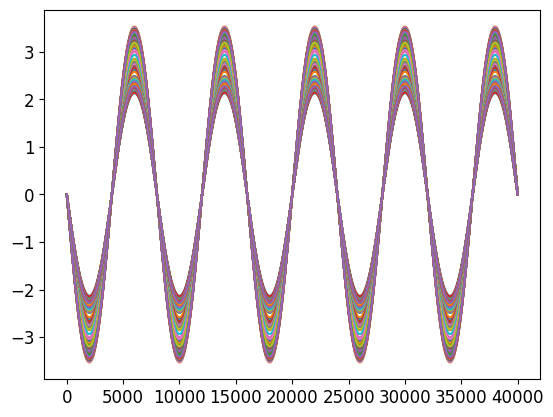

In [11]:
print(np.shape(v_cell_ext))
for v in v_cell_ext:
    plt.plot(v)


 {'cellType': 'L5_TTPC2_cADpyr232_1', 'cellModel': 'HH_full', 'pop': 'L5_TTPC', 'x': 0, 'y': 857, 'z': 0, 'xnorm': 0.0, 'ynorm': 8.57, 'znorm': 0.0}

 {'cellType': 'L5_TTPC2_cADpyr232_1', 'cellModel': 'HH_full', 'pop': 'L5_TTPC', 'x': 250, 'y': 1107, 'z': 0, 'xnorm': 2.5, 'ynorm': 11.07, 'znorm': 0.0}

 {'cellType': 'L5_TTPC2_cADpyr232_1', 'cellModel': 'HH_full', 'pop': 'L5_TTPC', 'x': 500, 'y': 1357, 'z': 0, 'xnorm': 5.0, 'ynorm': 13.57, 'znorm': 0.0}


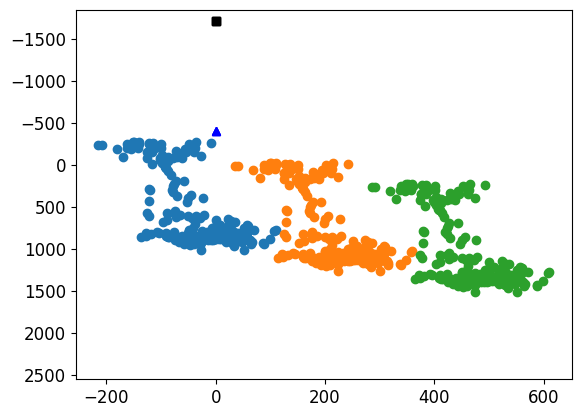

In [12]:
#Add extracellular stim
for c,metype in enumerate(sim.net.cells):
    if 'presyn' not in metype.tags['pop']:
        print("\n", metype.tags)
        plt.plot(0,-400,'b^')
        plt.plot(acs_params['position'][0],acs_params['position'][1],'ks')
        secList = [secs for secs in metype.secs.keys() if "pt3d" in metype.secs[secs]['geom']]
        plt.plot(np.array(getSecsPos(metype, secList)[0]),-1*np.array(getSecsPos(metype, secList)[1]),'o')
        plt.ylim(2550,-1850)
        # print(np.array(getSecsPos(cell, secList)[0]).mean(axis=-1),-1*np.array(getSecsPos(cell, secList)[1]).mean(axis=-1),np.array(getSecsPos(cell, secList)[2]).mean(axis=-1))

Plotting LFP electrode locations...
Plotting 3D cell shape ...
Preparing LFP data...
Plotting LFP time series...


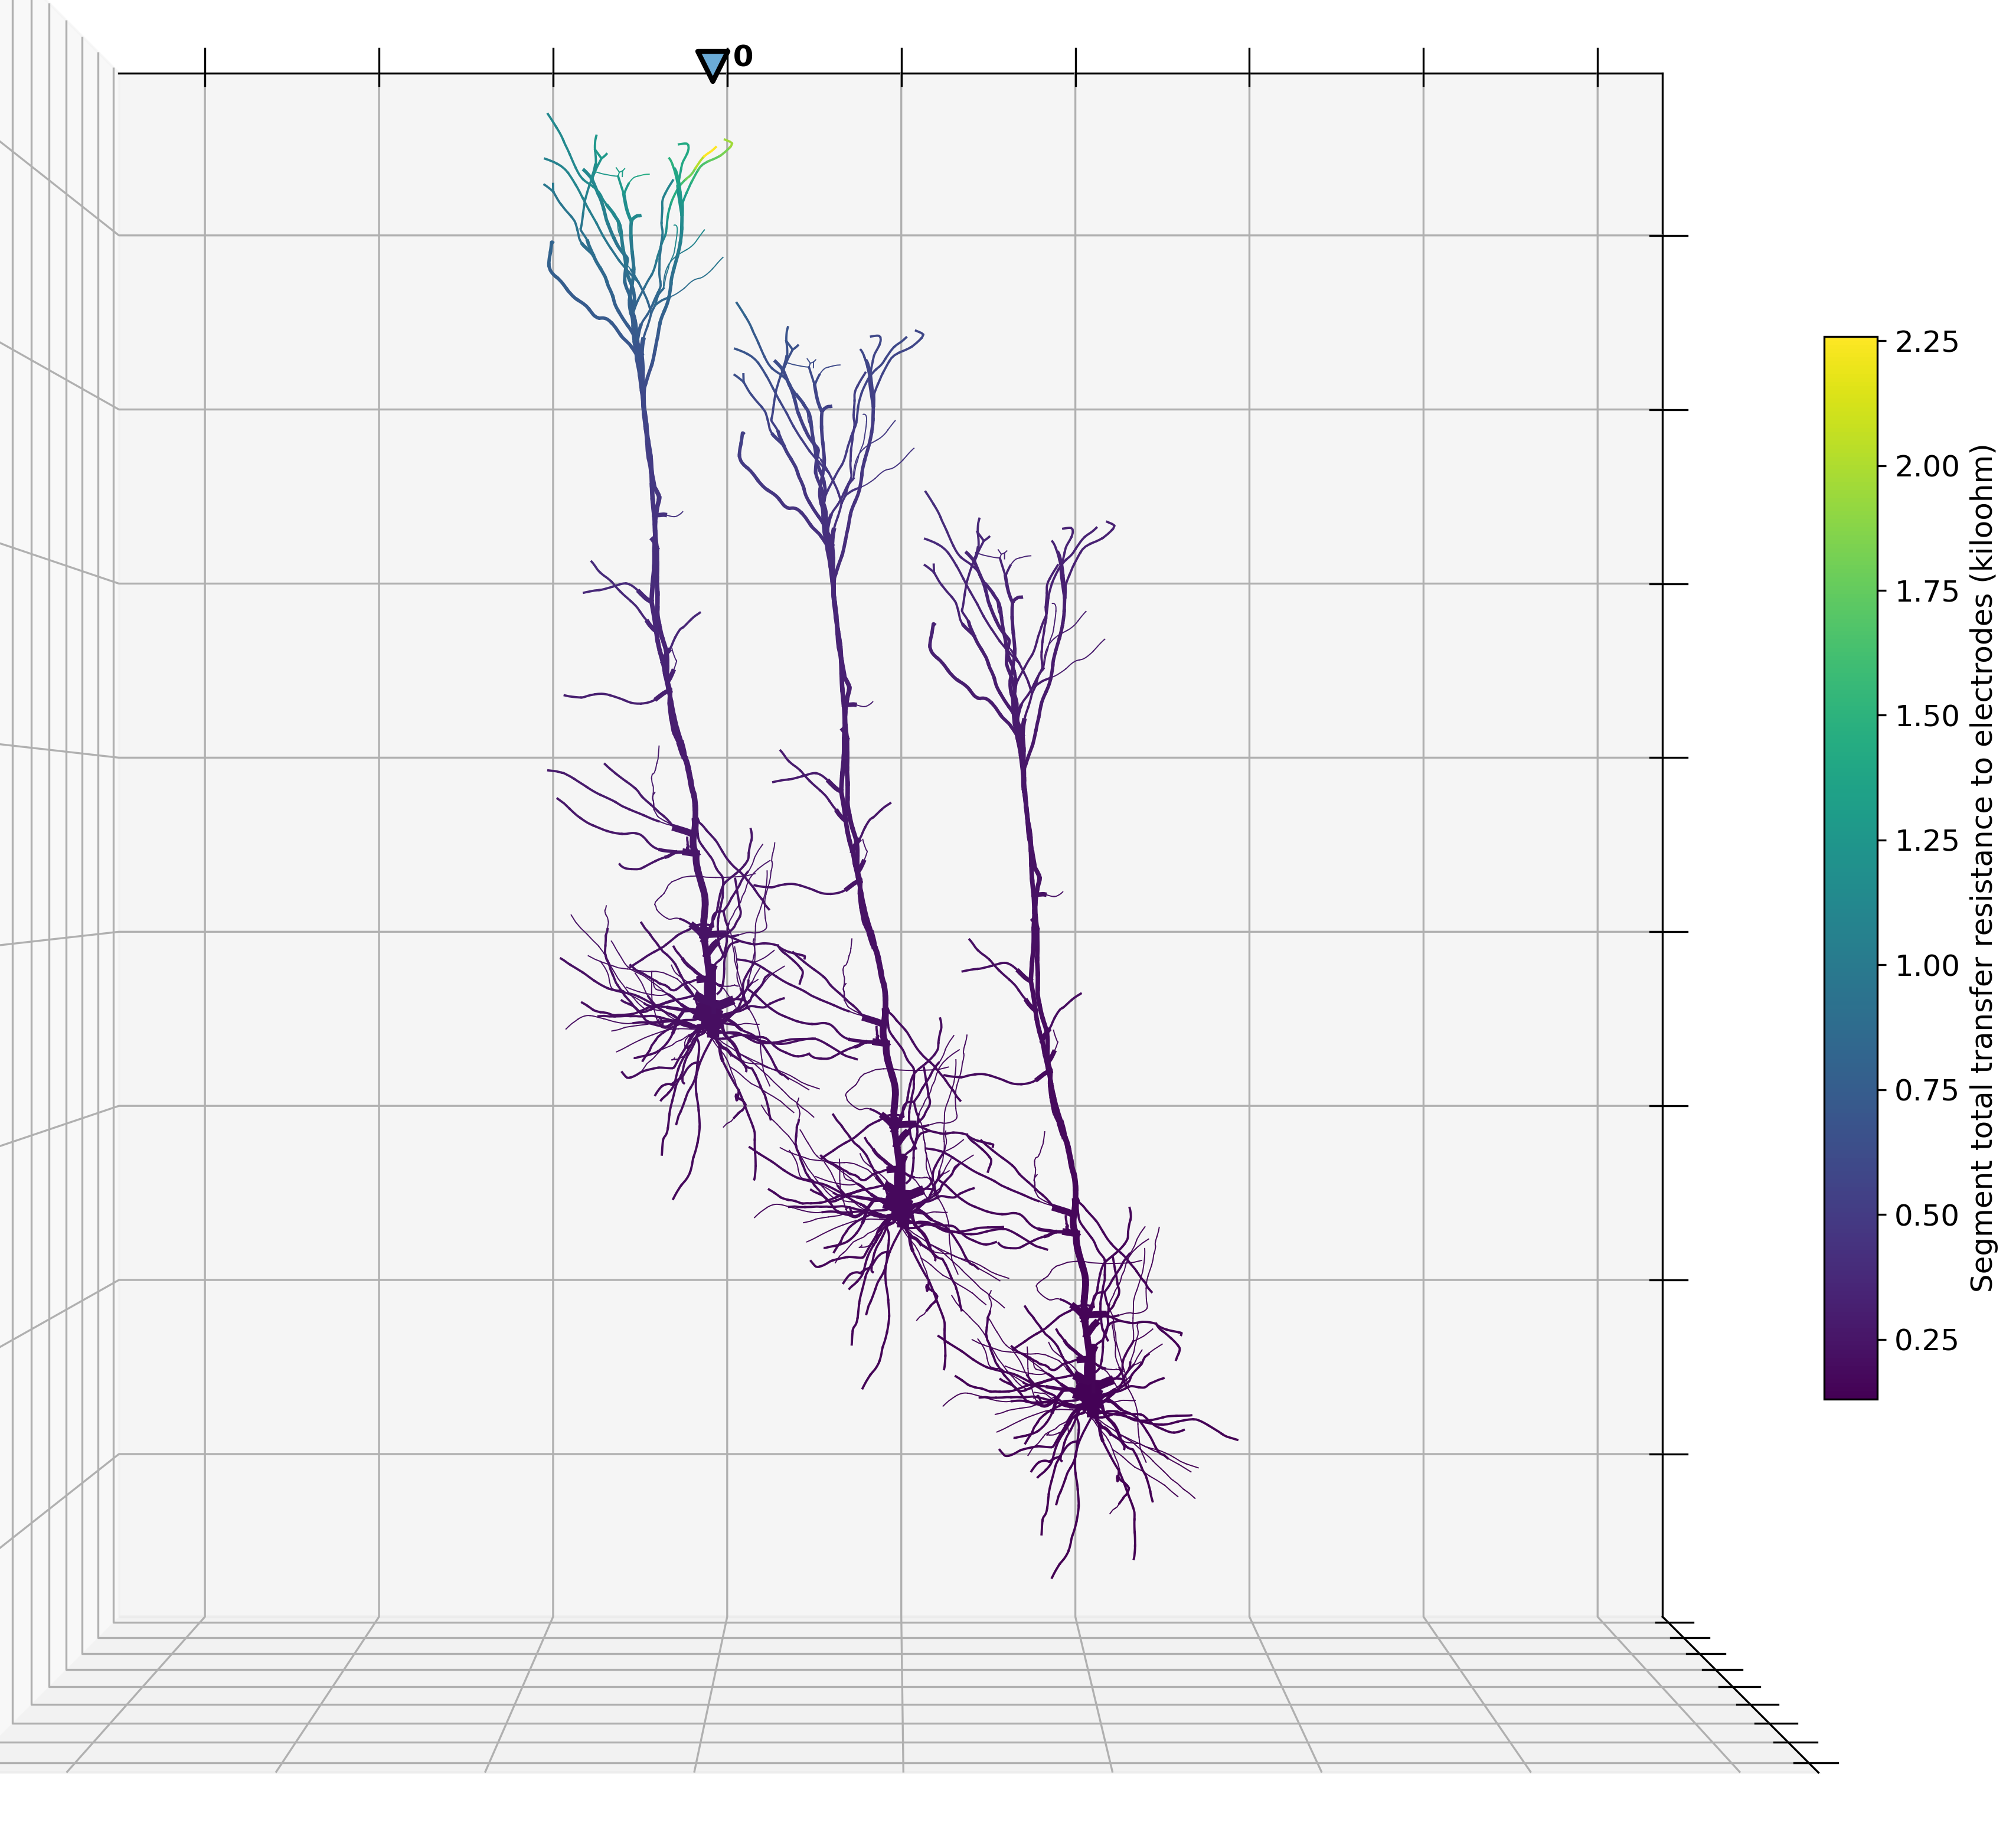

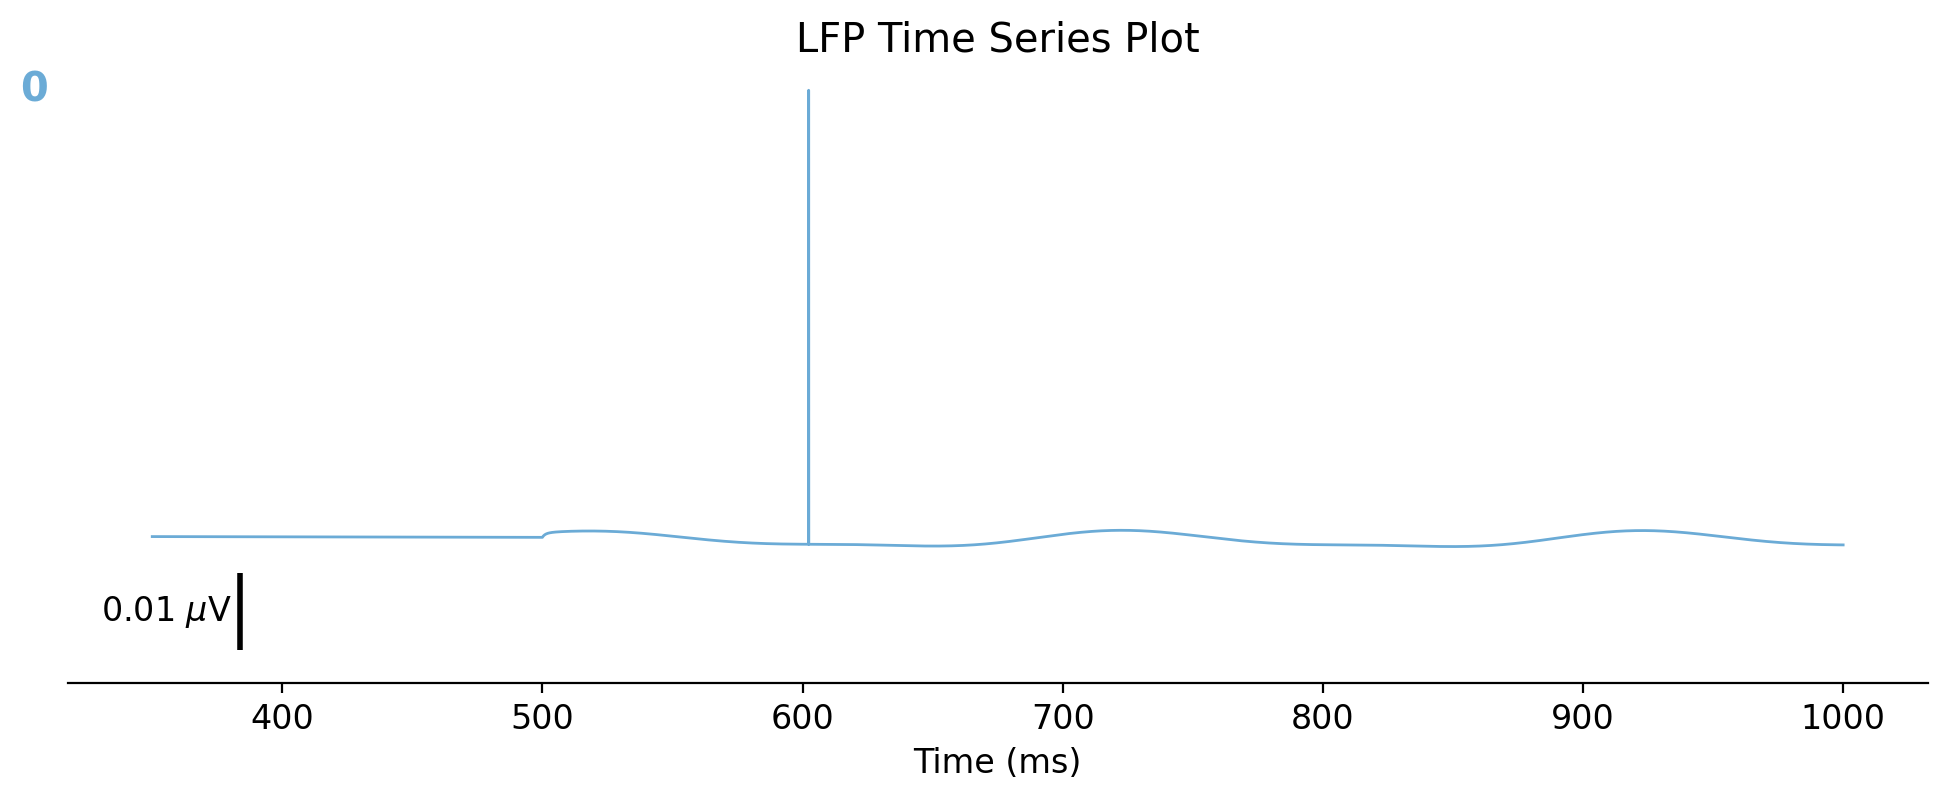

In [13]:
sim.analysis.plotLFP(**{'plots': ['locations'], 
        'figSize': (12,12), 
        'saveData': False, 
        'saveFig': False, 'showFig': False, 'dpi': 300})

sim.analysis.plotLFP(**{'plots': ['timeSeries'], 
        'electrodes': [0], #'avg', 
        'timeRange': [350, cfg.duration], 
        'figSize': (12,4), 'saveFig': False, 'showFig': False})

Plotting 3D cell shape ...
Plotting 3D cell shape ...


(<Figure size 640x480 with 2 Axes>, {})

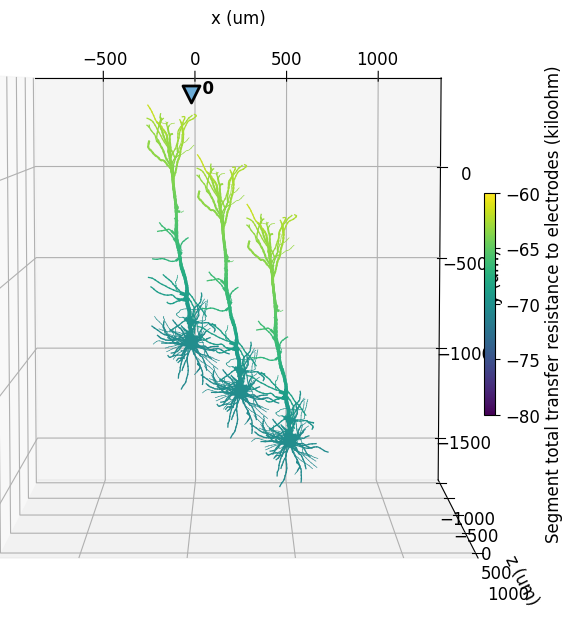

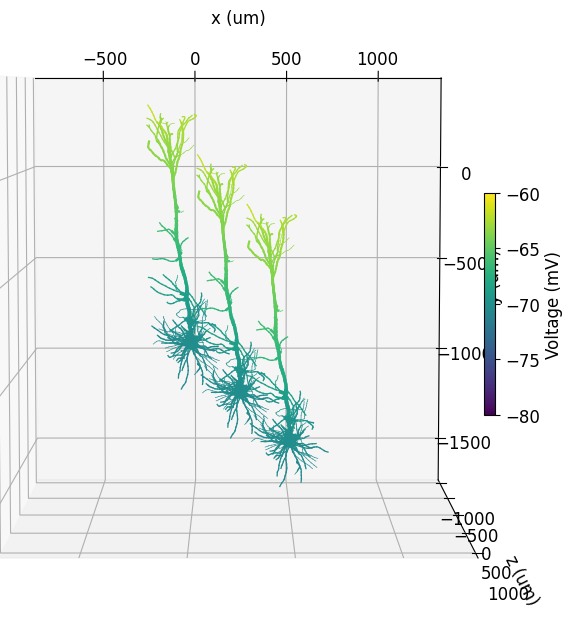

In [14]:
sim.analysis.plotShape(includePre=['L5_TTPC'], includePost=['L5_TTPC'], includeAxon=False, showSyns=False, showElectrodes=[0],
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-80, -60], showFig=False, synSize=2)
sim.analysis.plotShape(includePre=['L5_TTPC'], includePost=['L5_TTPC'], includeAxon=True, showSyns=False, showElectrodes=False,
    cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
    axisLabels=True, synStyle='o', 
    clim= [-80, -60], showFig=False, synSize=2)

Plotting recorded cell traces ... trace


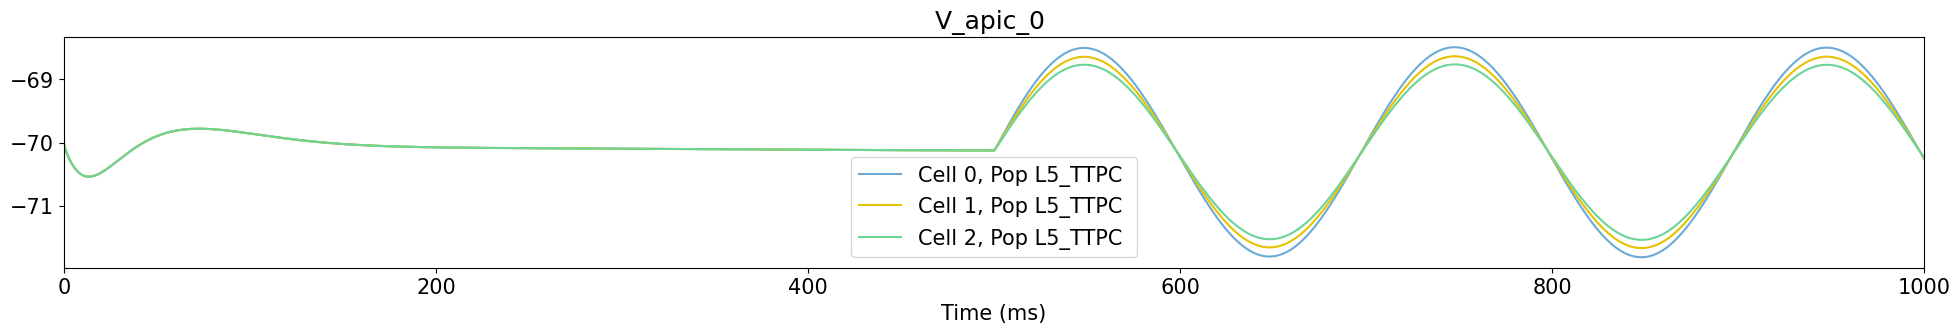

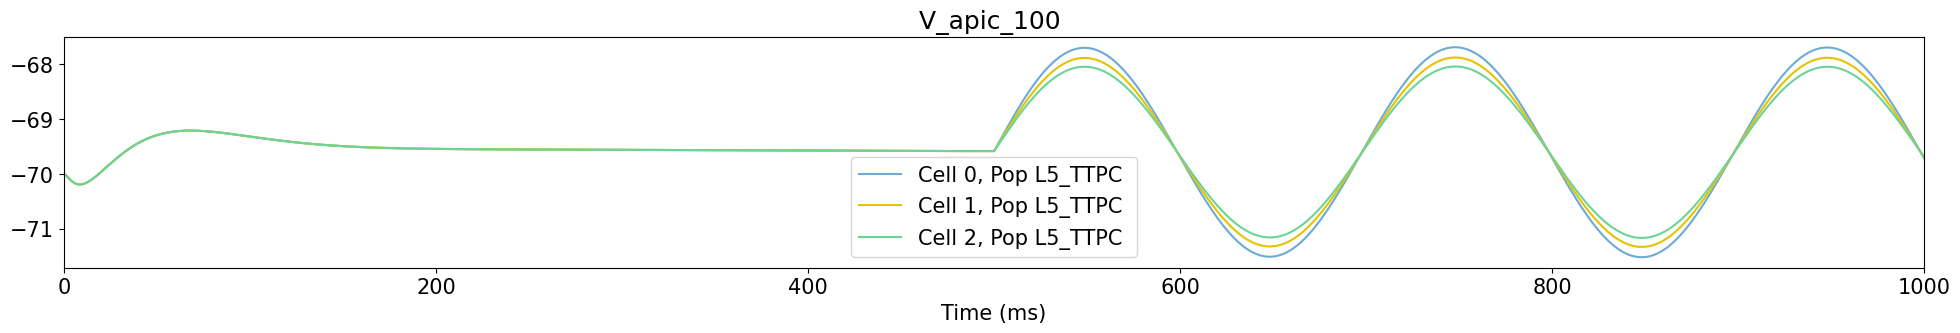

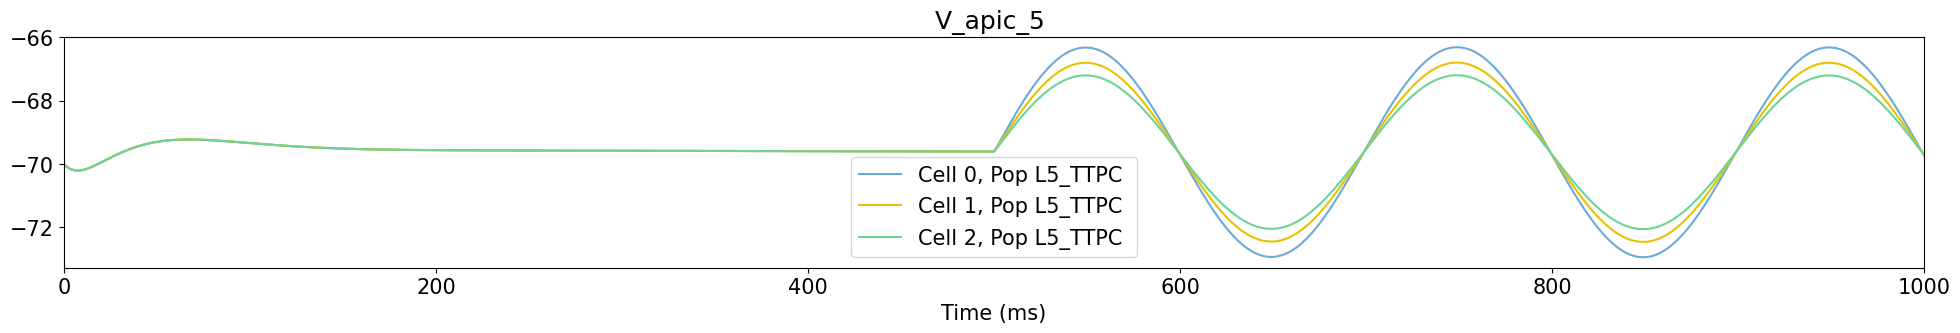

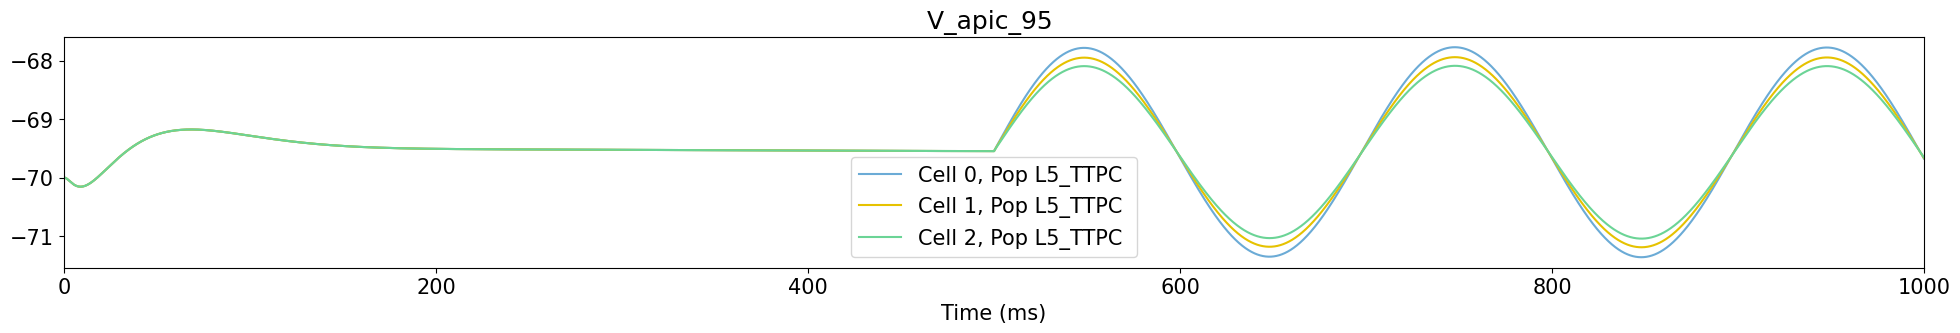

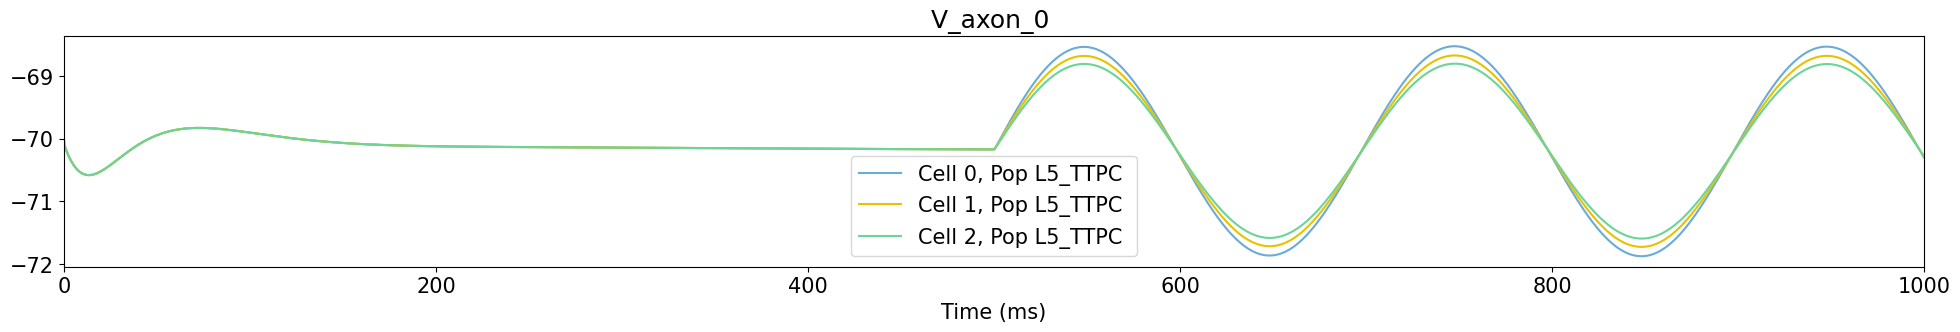

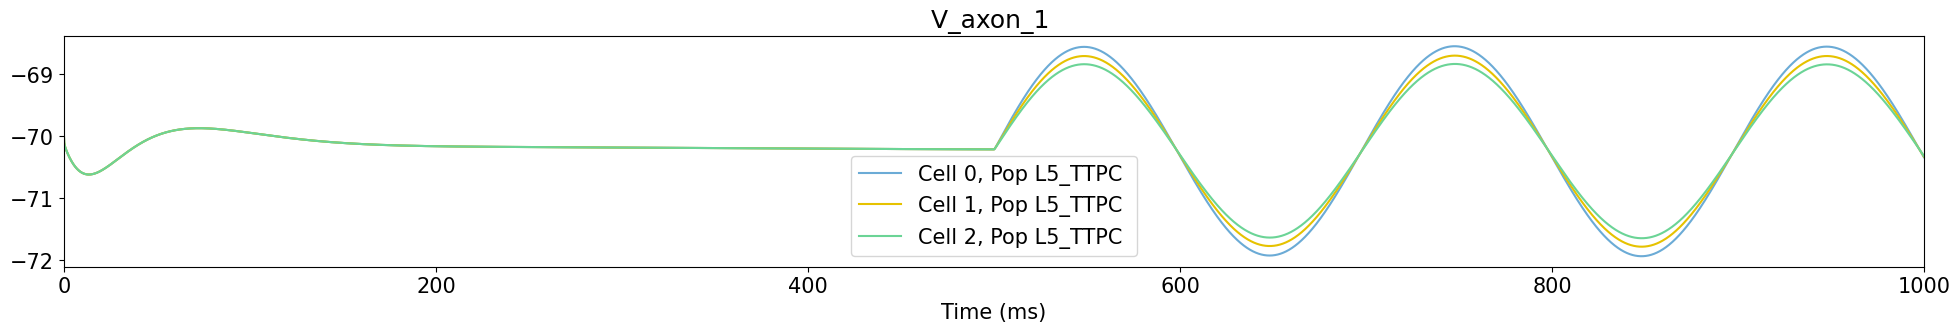

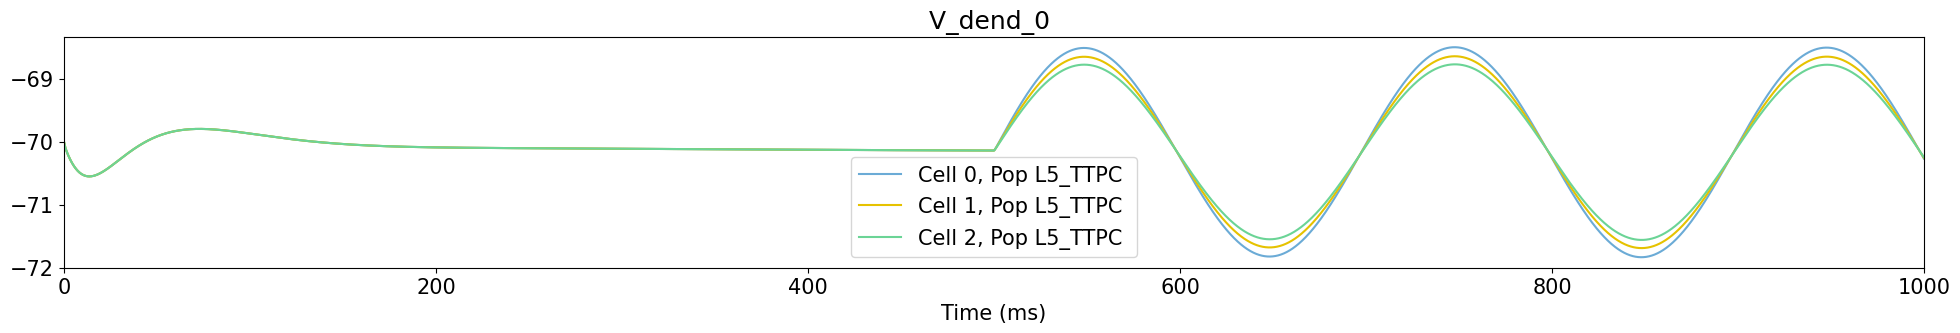

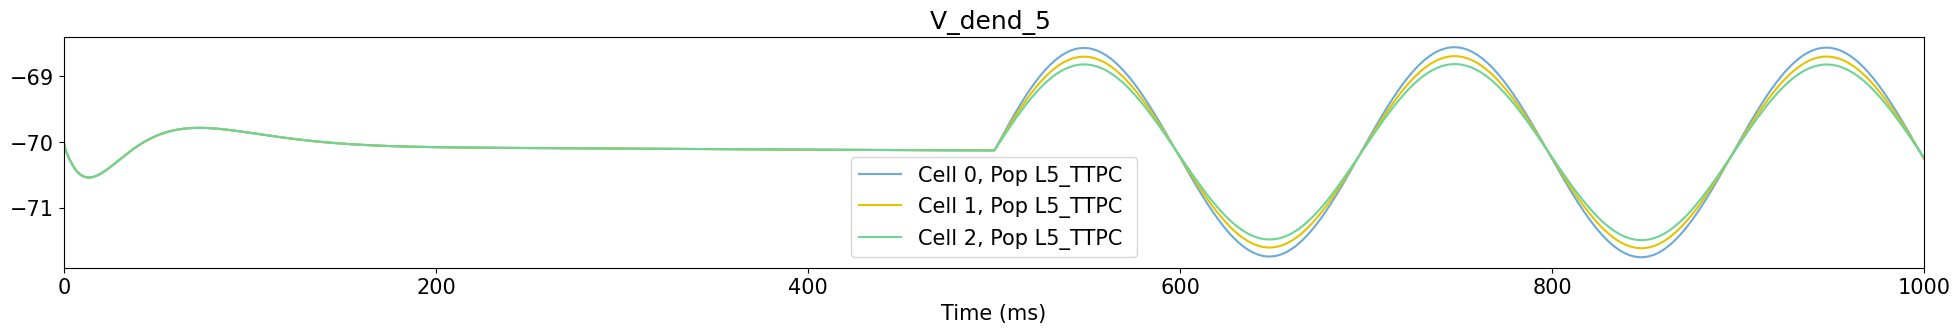

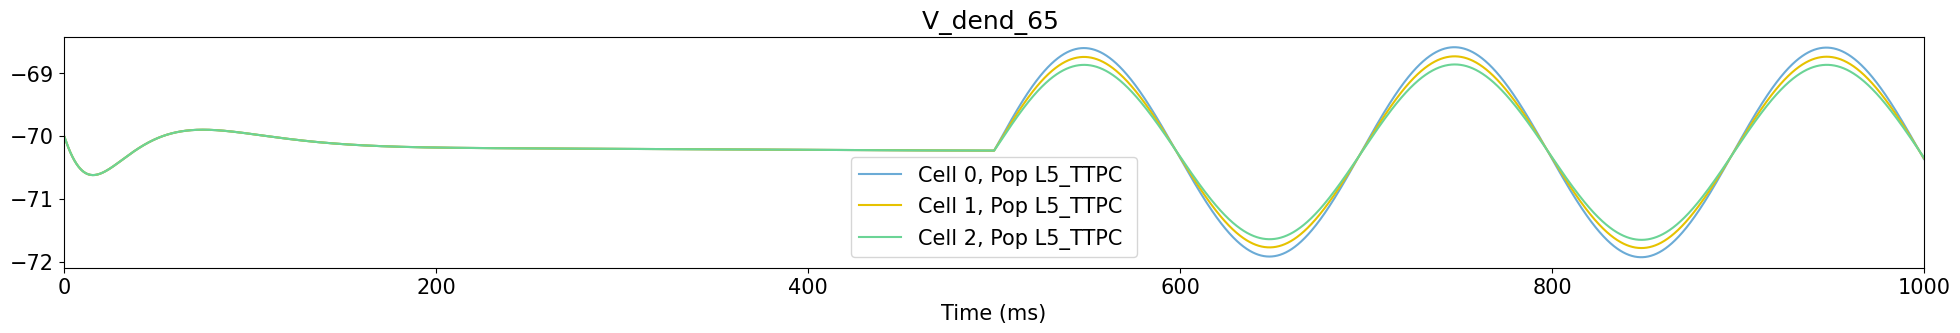

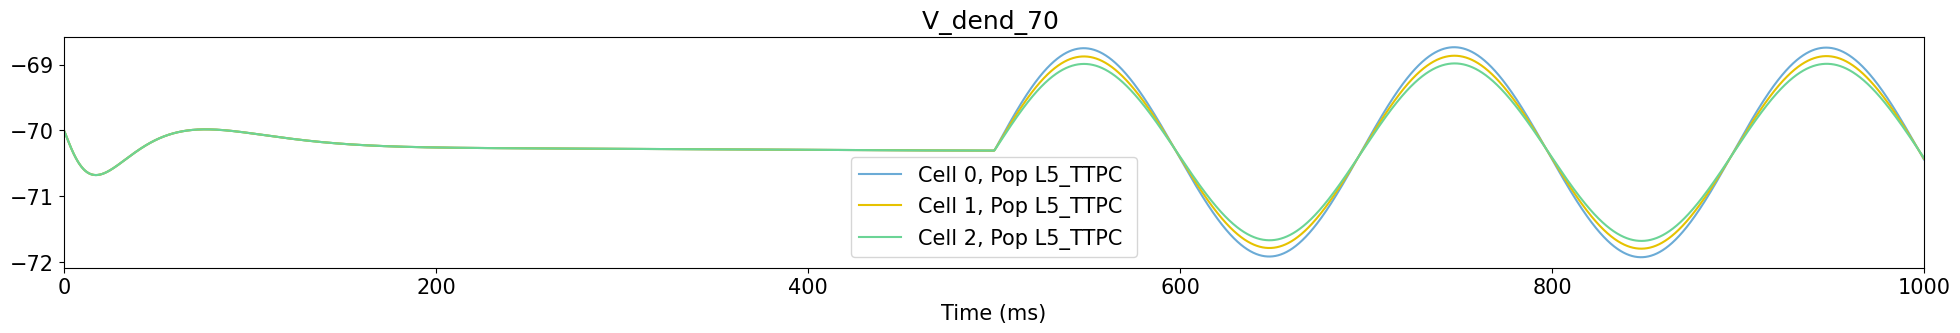

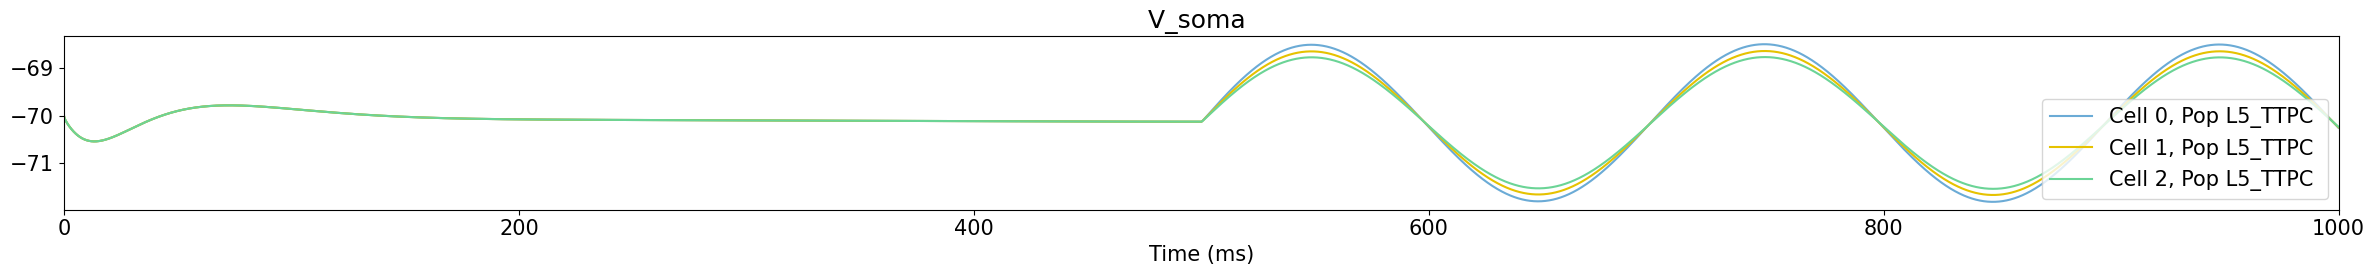

In [15]:
sim.analysis.plotTraces(overlay=True, oneFigPer='trace', figSize=(24,3), fontSize=15, saveFig=False);

In [16]:
netParams.cellParams['L5_TTPC2_cADpyr232_1_rule']['secs']['dend_0']

{geom: {L: 53.685639558562464, nseg: 3, diam: 1.010436106488544, Ra: 100.0, cm: 2.0, pt3d: [(-11.258600234985352, 0.7067109942436218, 1.0387200117111206, 1.3799999952316284), (-8.095190048217773, 0.5081430077552795, 0.74686598777771, 1.3799999952316284), (-9.68239974975586, 1.1027799844741821, 0.17419399321079254, 1.3799999952316284), (-11.7298002243042, 1.7016500234603882, -0.5679159760475159, 1.3799999952316284), (-13.952099800109863, 2.3211801052093506, -1.3875399827957153, 1.3799999952316284), (-15.979999542236328, 2.9784700870513916, -2.1378400325775146, 1.3799999952316284), (-18.765499114990234, 4.009230136871338, -3.175410032272339, 1.3799999952316284), (-21.087600708007812, 4.900899887084961, -3.9920599460601807, 1.3799999952316284), (-23.422500610351562, 5.7498698234558105, -4.722690105438232, 1.3799999952316284), (-25.443899154663086, 6.54079008102417, -5.281030178070068, 0.9200000166893005), (-28.85420036315918, 8.054380416870117, -6.091370105743408, 0.9200000166893005), (-3

In [17]:
for section in netParams.cellParams['L5_TTPC2_cADpyr232_1_rule']['secLists']['axonal']:
    print(section,'->',netParams.cellParams['L5_TTPC2_cADpyr232_1_rule']['secs'][section]['topol']['parentSec'])

axon_0 -> soma_0
axon_1 -> axon_0


Plotting 2D representation of network cell locations and connections...


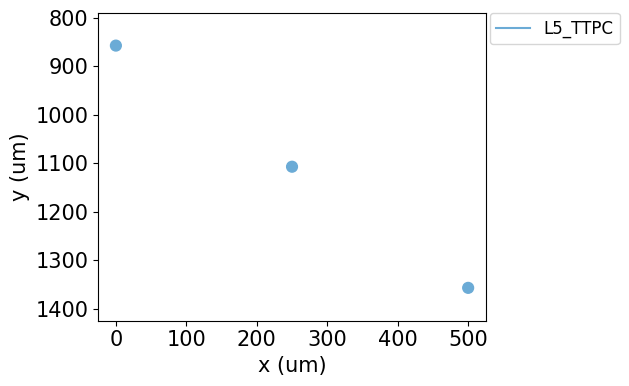

(<Figure size 500x400 with 1 Axes>,
 {'include': ['allCells'],
  'posX': [0, 250, 500],
  'posY': [857, 1107, 1357],
  'posXpre': [],
  'posXpost': [],
  'posYpre': [],
  'posYpost': []})

In [18]:
sim.analysis.plot2Dnet(figSize=(5, 4), fontSize=12)